In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [2]:
data = np.loadtxt('../Data_USL/s3.txt')

# K-Means

In [3]:
def kmeans(data, k, max_iter=300):
    # data -> array of data points
    # k -> number of clusters/centroids
    n_points = data.shape[0]
    tmp_arr = data[np.random.choice(n_points, size=k, replace=False)]
    init_positions = tmp_arr.copy()
    
    for i in range(max_iter):
        dist_sq = distance.cdist(data,init_positions,metric='sqeuclidean')
        dist_sq_min = np.array([np.min(dist_sq, axis=1)])
        labels = np.argmin(dist_sq, axis=1)
        total_loss = dist_sq_min.sum()
        flag = False
        
        for j in range(k):
            if len(data[labels==j]) == 0:
                flag = True
        
        if flag == True:
            tmp_arr = data[np.random.choice(n_points, size=k, replace=False)]
            init_positions = tmp_arr.copy()
            continue
        
        new_positions = np.array([data[labels==l].mean(axis=0) for l in range(k)])    
                
        if np.all(init_positions == new_positions):
            break
        
        init_positions = new_positions
        
    #print("Reached Maximum Number of Iterations")
    return total_loss, i, labels, new_positions

In [4]:
def cluster_plot(data,k,labels,centroid_positions):
    n_points = data.shape[0]
    plt.figure(figsize=(7,5))
    for i in range(k):
        array = data[labels==i]
        plt.scatter(array[:,0],array[:,1],s=4)
    plt.scatter(centroid_positions[:,0],centroid_positions[:,1],s=12,c='k')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [5]:
%%time
loss_val, iter_, labels, centroid_positions = kmeans(data,15)
print(loss_val, iter_)

18682674819314.273 18
CPU times: user 175 ms, sys: 7.68 ms, total: 183 ms
Wall time: 182 ms


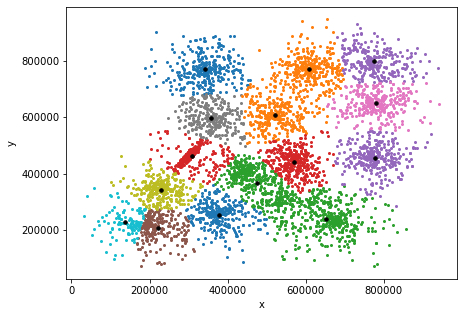

In [6]:
cluster_plot(data,15,labels,centroid_positions)

### Assignation for best case (k=15): K-Means

Average Loss: 19600032050111.418
Minimum Loss: 16889571849356.738


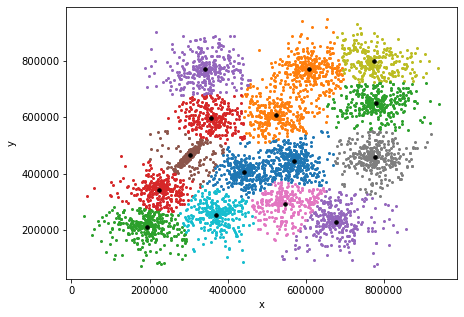

CPU times: user 12.7 s, sys: 0 ns, total: 12.7 s
Wall time: 12.7 s


In [7]:
%%time
k = 15
n_iter = 100
min_loss_val = +np.inf
loss_vals = np.zeros(n_iter)

for i in range(n_iter):
    loss_val, iter_, labels, centroid_positions = kmeans(data,k)
    if loss_val < min_loss_val:
        min_loss_val = loss_val
        best_centroid_positions = centroid_positions
        best_labels = labels
    loss_vals[i] = loss_val
    
print("Average Loss:", loss_vals.mean())
print("Minimum Loss:", loss_vals.min())

cluster_plot(data,15,best_labels,best_centroid_positions)   

### Scree Plot for K-Means for best value of loss function

K = 2, Average Loss: 210428334804957.47, Minimum Loss: 210428334804957.56
K = 3, Average Loss: 144384544756915.12, Minimum Loss: 139614749639647.7
K = 4, Average Loss: 91771688234346.52, Minimum Loss: 91771622303874.1
K = 5, Average Loss: 76005490484578.02, Minimum Loss: 75054113455106.05
K = 6, Average Loss: 63868014994611.37, Minimum Loss: 61402054460435.74
K = 7, Average Loss: 52514217257598.73, Minimum Loss: 50219935269293.875
K = 8, Average Loss: 43838307784058.89, Minimum Loss: 42058196688047.5
K = 9, Average Loss: 37547328222888.1, Minimum Loss: 36048589584476.06
K = 10, Average Loss: 32547592600201.15, Minimum Loss: 30332860333232.836
K = 11, Average Loss: 28590896849191.926, Minimum Loss: 27297323176910.656
K = 12, Average Loss: 25434537740026.613, Minimum Loss: 24424386696092.227
K = 13, Average Loss: 23236309158667.547, Minimum Loss: 21767478034386.406
K = 14, Average Loss: 21069337049154.426, Minimum Loss: 19211020216301.234
K = 15, Average Loss: 19524376529239.496, Minimum

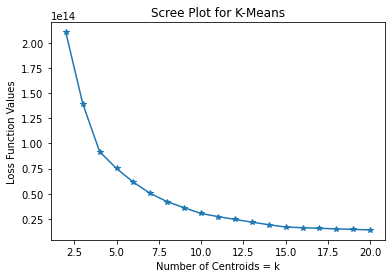

CPU times: user 2min 21s, sys: 11.7 ms, total: 2min 21s
Wall time: 2min 21s


In [8]:
%%time

n_iter = 100
min_k = 2
max_k = 21
scree_vals = np.empty((max_k-min_k,2))

for count,k in enumerate(range(min_k,max_k)):
    min_loss_val = +np.inf
    loss_vals = np.zeros(n_iter)

    for i in range(n_iter):
        loss_val, _, _, _ = kmeans(data,k)
        if loss_val < min_loss_val:
            min_loss_val = loss_val
        loss_vals[i] = loss_val
    
    print("K = {0}, Average Loss: {1}, Minimum Loss: {2}"
          .format(k, loss_vals.mean(), loss_vals.min()))
    
    scree_vals[count,0] = k
    scree_vals[count,1] = loss_vals.min()
    
plt.title("Scree Plot for K-Means")
plt.ylabel("Loss Function Values")
plt.xlabel("Number of Centroids = k")
plt.plot(scree_vals[:,0],scree_vals[:,1],'*-')
plt.show()

# K-Means++

In [9]:
def kmeans_pp_init(data, k):
    centroids = data[np.random.choice(data.shape[0],1,replace=False)] # chosen randomly to start with
    kmpp_init_centroids = np.empty((k, data.shape[1]))
    kmpp_init_centroids[0] = centroids
    for i in range(1,k):
        dist_sq = distance.cdist(data, centroids, metric='sqeuclidean')
        probability = np.squeeze(dist_sq/np.sum(dist_sq))
        new_centroid = data[np.random.choice(data.shape[0], 1, replace=False, p=probability)]
        
        if new_centroid in kmpp_init_centroids:
            i = i - 1 # choose new centroid and repeat this iteration
        else:
            kmpp_init_centroids[i] = new_centroid.copy()
            centroids = new_centroid.copy()
        
    return kmpp_init_centroids

In [10]:
def kmeans_pp(data, k, max_iter=300):
    # data -> array of data points
    # k -> number of clusters/centroids
    n_points = data.shape[0]
    
    # Here, we initialize differently for KMeans++
    #tmp_arr = data[np.random.choice(n_points, size=k, replace=False)]
    #init_positions = tmp_arr.copy()
    init_positions = kmeans_pp_init(data,k) 
        
    for i in range(max_iter):
        dist_sq = distance.cdist(data,init_positions,metric='sqeuclidean')
        dist_sq_min = np.array([np.min(dist_sq, axis=1)])
        labels = np.argmin(dist_sq, axis=1)
        total_loss = dist_sq_min.sum()
        flag = False
        
        for j in range(k):
            if len(data[labels==j]) == 0:
                flag = True
        
        if flag == True:
            tmp_arr = data[np.random.choice(n_points, size=k, replace=False)]
            init_positions = tmp_arr.copy()
            continue
        
        new_positions = np.array([data[labels==l].mean(axis=0) for l in range(k)])    
                
        if np.all(init_positions == new_positions):
            break
        
        init_positions = new_positions
        
    #print("Reached Maximum Number of Iterations")
    return total_loss, i, labels, new_positions

In [11]:
%%time
loss_val, iter_, labels, centroid_positions = kmeans_pp(data,15)
print(loss_val, iter_)

19199869362613.047 33
CPU times: user 199 ms, sys: 7.99 ms, total: 207 ms
Wall time: 201 ms


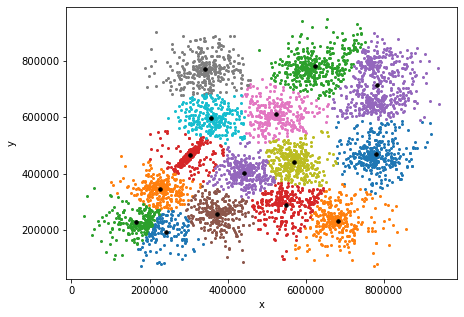

In [12]:
cluster_plot(data,15,labels,centroid_positions)

### Assignation for best case (k=15): K-Means++

Average Loss: 19362513769445.76
Minimum Loss: 16889803051008.586


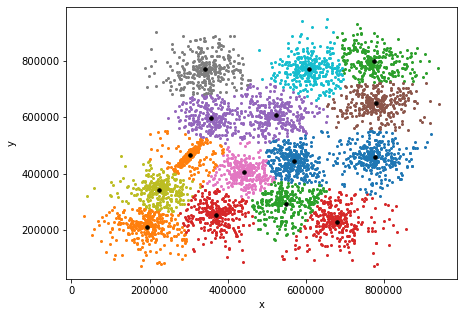

CPU times: user 10 s, sys: 8.02 ms, total: 10 s
Wall time: 10 s


In [13]:
%%time
k = 15
n_iter = 100
min_loss_val = +np.inf
loss_vals = np.zeros(n_iter)

for i in range(n_iter):
    loss_val, iter_, labels, centroid_positions = kmeans_pp(data,k)
    if loss_val < min_loss_val:
        min_loss_val = loss_val
        best_centroid_positions = centroid_positions
        best_labels = labels
    loss_vals[i] = loss_val
    
print("Average Loss:", loss_vals.mean())
print("Minimum Loss:", loss_vals.min())

cluster_plot(data,15,best_labels,best_centroid_positions)   

### Scree Plot for K-Means++ for best value of loss function

K = 2, Average Loss: 210428334804957.47, Minimum Loss: 210428334804957.56
K = 3, Average Loss: 144652988868287.8, Minimum Loss: 139614749639647.7
K = 4, Average Loss: 91771655244447.48, Minimum Loss: 91771622303874.1
K = 5, Average Loss: 75800198950629.61, Minimum Loss: 75054113455106.05
K = 6, Average Loss: 63617367504834.8, Minimum Loss: 61401881375290.59
K = 7, Average Loss: 52705896417018.17, Minimum Loss: 50219462491968.78
K = 8, Average Loss: 43765720610055.59, Minimum Loss: 42058351251110.61
K = 9, Average Loss: 37130649993985.81, Minimum Loss: 36048589584476.06
K = 10, Average Loss: 32015071902914.38, Minimum Loss: 30332860333232.836
K = 11, Average Loss: 28138324922424.79, Minimum Loss: 27297261642228.04
K = 12, Average Loss: 25213946538310.395, Minimum Loss: 24424376692864.906
K = 13, Average Loss: 22949451745916.83, Minimum Loss: 21805690097854.535
K = 14, Average Loss: 20996752287823.176, Minimum Loss: 19210855194120.21
K = 15, Average Loss: 19461952504063.36, Minimum Loss:

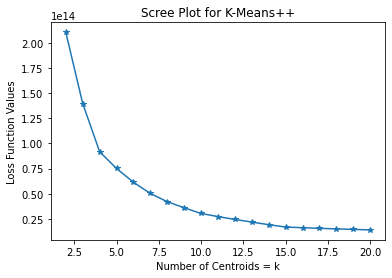

CPU times: user 2min 45s, sys: 35.8 ms, total: 2min 46s
Wall time: 2min 46s


In [14]:
%%time

n_iter = 100
min_k = 2
max_k = 21
scree_vals = np.empty((max_k-min_k,2))

for count,k in enumerate(range(min_k,max_k)):
    min_loss_val = +np.inf
    loss_vals = np.zeros(n_iter)

    for i in range(n_iter):
        loss_val, _, _, _ = kmeans_pp(data,k)
        if loss_val < min_loss_val:
            min_loss_val = loss_val
        loss_vals[i] = loss_val
    
    print("K = {0}, Average Loss: {1}, Minimum Loss: {2}"
          .format(k, loss_vals.mean(), loss_vals.min()))
    
    scree_vals[count,0] = k
    scree_vals[count,1] = loss_vals.min()
    
plt.title("Scree Plot for K-Means++")
plt.ylabel("Loss Function Values")
plt.xlabel("Number of Centroids = k")
plt.plot(scree_vals[:,0],scree_vals[:,1],'*-')
plt.show()

# Fuzzy C-Means

In [15]:
def cmeans(data,k,m=2,eps=1.e-5,max_iter=300):
    # m is fuzzification parameter, usually = 2
    # k -> number of clusters/centroids
    n_points = data.shape[0]
    u = np.random.random((n_points,k))
    diff_u = np.ones((n_points, k))
    u = u / np.sum(u,axis=1)[:,np.newaxis]
    counter = 0
    while np.max(diff_u) > eps:
        counter += 1
        centroid_positions = np.dot(u.T**m,data)/np.sum(u.T**m, axis=1)[:,np.newaxis]
        u_new = 1/((distance.cdist(data, centroid_positions)/
                    np.sum(distance.cdist(data, centroid_positions), axis=1)[:,np.newaxis])**(2/(m-1)))
        u_new = u_new / np.sum(u_new,axis=1)[:,np.newaxis]
        diff_u = np.abs(u_new - u)
        u = u_new.copy()
        total_loss = np.sum((distance.cdist(data, centroid_positions, metric='sqeuclidean'))*(u**m))
        labels = np.argmax(u, axis=1)
    return total_loss, counter, labels, centroid_positions

In [16]:
%%time
loss_val, iter_, labels, centroid_positions = cmeans(data, 15)
print(loss_val, iter_)

7988108819394.179 41
CPU times: user 941 ms, sys: 20 ms, total: 961 ms
Wall time: 245 ms


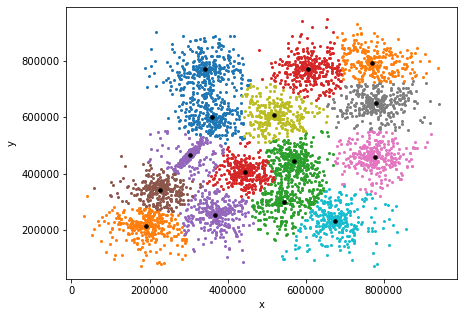

In [17]:
cluster_plot(data,15,labels,centroid_positions)

### Assignation for best case (k=15): Fuzzy C-Means

Average Loss: 8217268492074.575
Minimum Loss: 7988108819357.711


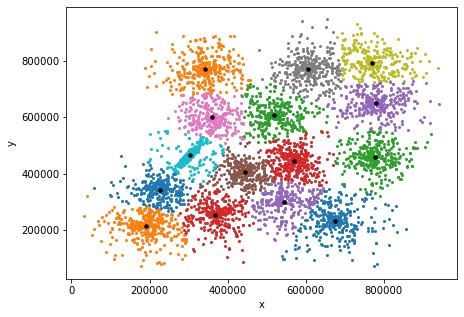

CPU times: user 4min 2s, sys: 3.85 s, total: 4min 6s
Wall time: 1min 2s


In [18]:
%%time
k = 15
n_iter = 100
min_loss_val = +np.inf
loss_vals = np.zeros(n_iter)

for i in range(n_iter):
    loss_val, iter_, labels, centroid_positions = cmeans(data,k)
    if loss_val < min_loss_val:
        min_loss_val = loss_val
        best_centroid_positions = centroid_positions
        best_labels = labels
    loss_vals[i] = loss_val
    
print("Average Loss:", loss_vals.mean())
print("Minimum Loss:", loss_vals.min())

cluster_plot(data,15,best_labels,best_centroid_positions)   

### Scree Plot for Fuzzy C-Means for best value of loss function

K = 2, Average Loss: 154248968482954.72, Minimum Loss: 154248968468878.97
K = 3, Average Loss: 90622636194465.4, Minimum Loss: 90622636180419.25
K = 4, Average Loss: 58128291367191.48, Minimum Loss: 58128291363572.945
K = 5, Average Loss: 43719561829932.73, Minimum Loss: 43719561828095.33
K = 6, Average Loss: 33771945143418.906, Minimum Loss: 33658231129691.594
K = 7, Average Loss: 26789137062475.562, Minimum Loss: 26723405762550.688
K = 8, Average Loss: 22115325996421.086, Minimum Loss: 21845266546779.29
K = 9, Average Loss: 18416384224046.457, Minimum Loss: 18032847934879.41
K = 10, Average Loss: 15544284973776.957, Minimum Loss: 15270663058318.064
K = 11, Average Loss: 13589807598232.377, Minimum Loss: 13353942119509.262
K = 12, Average Loss: 11872731015787.328, Minimum Loss: 11631858697844.969
K = 13, Average Loss: 10470428170963.477, Minimum Loss: 10160937291443.258
K = 14, Average Loss: 9336885354862.81, Minimum Loss: 9067359368129.137
K = 15, Average Loss: 8385030255692.144, Min

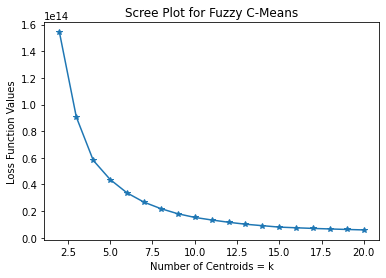

CPU times: user 7min 53s, sys: 6.45 s, total: 8min
Wall time: 2min 1s


In [19]:
%%time

n_iter = 10 # reduced this from 100 to 10 otherwise it takes way too long to run
min_k = 2
max_k = 21
scree_vals = np.empty((max_k-min_k,2))

for count,k in enumerate(range(min_k,max_k)):
    min_loss_val = +np.inf
    loss_vals = np.zeros(n_iter)

    for i in range(n_iter):
        loss_val, _, _, _ = cmeans(data,k)
        if loss_val < min_loss_val:
            min_loss_val = loss_val
        loss_vals[i] = loss_val
    
    print("K = {0}, Average Loss: {1}, Minimum Loss: {2}"
          .format(k, loss_vals.mean(), loss_vals.min()))
    
    scree_vals[count,0] = k
    scree_vals[count,1] = loss_vals.min()
    
plt.title("Scree Plot for Fuzzy C-Means")
plt.ylabel("Loss Function Values")
plt.xlabel("Number of Centroids = k")
plt.plot(scree_vals[:,0],scree_vals[:,1],'*-')
plt.show()

# K-Medoids

In [20]:
def kmedoids(data, k, max_iter=300):
    # data -> array of data points
    # k -> number of medoids
    n_points = data.shape[0]
    init_position_idx = np.random.choice(n_points, size=k, replace=False)
    
    dist_matrix = distance.cdist(data,data,metric='sqeuclidean')
    
    for i in range(max_iter):
        old_position_idx = init_position_idx.copy()
        labels = np.argmin(dist_matrix[init_position_idx,:], axis=0)
        
        for l in range(k):
            idx_tmp = np.where(labels==l)[0]
            if len(idx_tmp) == 0:
                continue
            intra_cluster_dist = dist_matrix[idx_tmp,idx_tmp[:,np.newaxis]]
            intra_cluster_loss = intra_cluster_dist.sum(axis=1)
            min_loss = intra_cluster_loss[np.argmin(intra_cluster_loss)]
            loss_val_curr = intra_cluster_loss[np.argmax(idx_tmp == init_position_idx[l])]
            if min_loss < loss_val_curr:
                init_position_idx[l] = idx_tmp[np.argmin(intra_cluster_loss)]
        
        if np.all(old_position_idx == init_position_idx):
            break
            
    medoid_positions = data[init_position_idx]
    labels = np.argmin(dist_matrix[init_position_idx,:], axis = 0)
    dist_sq = distance.cdist(data,medoid_positions,metric='sqeuclidean')
    dist_sq_min = np.array([np.min(dist_sq, axis=1)])
    total_loss = dist_sq_min.sum()

    return total_loss, i, labels, medoid_positions

In [21]:
%%time
loss_val, iter_, labels, medoid_positions = kmedoids(data,15)
print(loss_val, iter_)

23525356661065.0 9
CPU times: user 467 ms, sys: 224 ms, total: 691 ms
Wall time: 694 ms


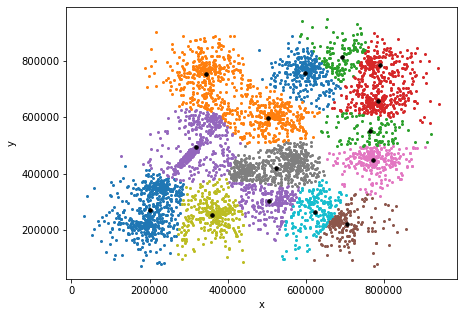

In [22]:
cluster_plot(data,15,labels,medoid_positions)

### Assignation for best case (k=15): K-Medoids

Average Loss: 20196999077259.9
Minimum Loss: 18798511009713.0


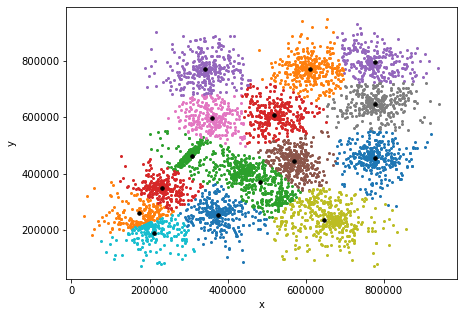

CPU times: user 6.6 s, sys: 1.86 s, total: 8.46 s
Wall time: 8.52 s


In [23]:
%%time
k = 15
n_iter = 10 # reduced this from 100 to 10 otherwise it takes way too long to run
min_loss_val = +np.inf
loss_vals = np.zeros(n_iter)

for i in range(n_iter):
    loss_val, iter_, labels, medoid_positions = kmedoids(data,k)
    if loss_val < min_loss_val:
        min_loss_val = loss_val
        best_medoid_positions = medoid_positions
        best_labels = labels
    loss_vals[i] = loss_val
    
print("Average Loss:", loss_vals.mean())
print("Minimum Loss:", loss_vals.min())

cluster_plot(data,15,best_labels,best_medoid_positions)   

### Scree Plot for K-Medoids for best value of loss function

K = 2, Average Loss: 211031130943627.4, Minimum Loss: 210687807269819.0
K = 3, Average Loss: 149463960996402.9, Minimum Loss: 139903777289318.0
K = 4, Average Loss: 92381112742893.7, Minimum Loss: 92057989043326.0
K = 5, Average Loss: 78490506722820.4, Minimum Loss: 75373577223418.0
K = 6, Average Loss: 66546271998932.5, Minimum Loss: 62238599641225.0
K = 7, Average Loss: 54045578969510.0, Minimum Loss: 50815292747947.0
K = 8, Average Loss: 45801775410945.5, Minimum Loss: 42165714962214.0
K = 9, Average Loss: 38680829429723.8, Minimum Loss: 36093929410271.0
K = 10, Average Loss: 34072831825436.6, Minimum Loss: 30362419096394.0
K = 11, Average Loss: 30158753722784.7, Minimum Loss: 27337405221654.0
K = 12, Average Loss: 26781905442287.4, Minimum Loss: 24499754675669.0
K = 13, Average Loss: 25203144516708.3, Minimum Loss: 21863413056274.0
K = 14, Average Loss: 22844055930879.3, Minimum Loss: 19448225897297.0
K = 15, Average Loss: 19243408408355.9, Minimum Loss: 16900053659453.0
K = 16, Av

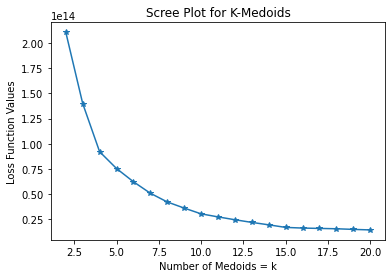

CPU times: user 2min 37s, sys: 44.9 s, total: 3min 22s
Wall time: 3min 24s


In [24]:
%%time

n_iter = 10 # reduced this from 100 to 10 otherwise it takes way too long to run
min_k = 2
max_k = 21
scree_vals = np.empty((max_k-min_k,2))

for count,k in enumerate(range(min_k,max_k)):
    min_loss_val = +np.inf
    loss_vals = np.zeros(n_iter)

    for i in range(n_iter):
        loss_val, _, _, _ = kmedoids(data,k)
        if loss_val < min_loss_val:
            min_loss_val = loss_val
        loss_vals[i] = loss_val
    
    print("K = {0}, Average Loss: {1}, Minimum Loss: {2}"
          .format(k, loss_vals.mean(), loss_vals.min()))
    
    scree_vals[count,0] = k
    scree_vals[count,1] = loss_vals.min()
    
plt.title("Scree Plot for K-Medoids")
plt.ylabel("Loss Function Values")
plt.xlabel("Number of Medoids = k")
plt.plot(scree_vals[:,0],scree_vals[:,1],'*-')
plt.show()